# **Stratigraphic Units using DBSCAN**

This work is the reproduction of the paper with title "[Data-driven identification of stratigraphic units in 3D seismic data using hierarchical density-based clustering](https://doi.org/10.1190/geo2019-0413.1)" by Aina Juell Bugge et al. There are some differences between this work with the [original one](https://github.com/ajbugge/StratigraphicUnits/blob/master/StratUnits.ipynb) is the usage of F3 Netherlands dataset (it is covered by the paper but it is not public or shared). The second difference from the original work is this one is using CUDA processing which is so faster.

Initially, let's install the dependencies including the orignal dependencies and CuPy with CUDA 10.2 (which is the target of this Python notebook). If you are using another CUDA version, install the proper one.

In [ ]:
!pip3 install segyio fsspec hdbscan scikit-image > /dev/null 2>&1
# Installing cupy for CUDA
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  19750      0 --:--:-- --:--:-- --:--:-- 19750
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9MB 48kB/s 
     |████████████████████████████████| 1.0MB 39.9MB/s 
+ set +ex
Installation succeeded!


###**Getting the Dataset**

Seismic datasets are usually computationally represented as 3D scalar fields, being each voxel of the volume a 32-bits floating-point (amplitude). The Society of Exploration Geophysics (SEG) made available an [online repository](https://wiki.seg.org/wiki/Open_data) with major surveys from onshore and offshore areas.

For this tutorial, we will use two marine seismic blocks from the Netherlands and New Zealand offshore regions (as the original paper does).

The dataset is the F3-Netherlands (https://wiki.seg.org/wiki/F3_Netherlands): a 1.2 GByte time migrated 3D seismic cube. It is available through the Creative Commons 3.0 license. Check the [dGB repository](https://terranubis.com/datainfo/F3-Demo-2020) for a complete reference.

The dataset was modified to adjust the header such that it could be read by the [segyio](https://github.com/equinor/segyio) library:


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D" -O F3.sgy && rm -rf /tmp/cookies.txt

--2021-06-28 03:35:08--  https://docs.google.com/uc?export=download&confirm=PilC&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D
Resolving docs.google.com (docs.google.com)... 172.217.15.78, 2607:f8b0:4004:810::200e
Connecting to docs.google.com (docs.google.com)|172.217.15.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5k-docs.googleusercontent.com/docs/securesc/sv1cqn3hgmld5tekd2ch66jde2o98g8h/jdisvh9olqnksr12go02f0k9amjrffni/1624851300000/17311170770924402329/12685074518923127319Z/1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D?e=download [following]
--2021-06-28 03:35:08--  https://doc-10-5k-docs.googleusercontent.com/docs/securesc/sv1cqn3hgmld5tekd2ch66jde2o98g8h/jdisvh9olqnksr12go02f0k9amjrffni/1624851300000/17311170770924402329/12685074518923127319Z/1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D?e=download
Resolving doc-10-5k-docs.googleusercontent.com (doc-10-5k-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-10-

###**Data Preparation**

Importing Python dependencies.


In [ ]:
# Basic imports.
import os
import segyio
import sys
import time
import numpy as np
import cupy as cp

# Dataframe libraries for attribute computation.
import dask.array as da
import dask.dataframe as ddf

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

%matplotlib inline

###**Reading Seismic Cubes**

Firstly, we will explore the impact of RAPIDS for seismic facies classification on the F3 seismic block.

Let's define the input file directory:

In [ ]:
input_file = 'F3.sgy'

Pre- and post-stack seismic cubes are often stored following the [SEG-Y standard](https://en.wikipedia.org/wiki/SEG-Y). Notice that most of the files available in SEG Open data repository are released as .sgy files.

Equinor made available an easy-to-use SEG-Y file reader with a Python interface. The segyio is a small LGPL licensed C library for easy interaction with SEG-Y and Seismic Unix formatted seismic data, with language bindings for both Python and Matlab.

Let's make a preliminary check on the seismic cubes using the **segyio** library and verify that number of inlines, crosslines, and time slices match the reference we have on SEG repository:

In [ ]:
def inspect_seismic_cubes(file_name):
    segy_file = segyio.open(file_name)
    iline_start = int(segy_file.ilines[0])
    iline_end = int(segy_file.ilines[-1])
    iline_offset = int(segy_file.ilines[1] - segy_file.ilines[0])

    xline_start = int(segy_file.xlines[0])
    xline_end = int(segy_file.xlines[-1])
    xline_offset = int(segy_file.xlines[1] - segy_file.xlines[0])

    time_start = int(segy_file.samples[0])
    time_end = int(segy_file.samples[-1])
    time_offset = int(segy_file.samples[1] - segy_file.samples[0])
        
    print("File: {} \n"
          "Inline range: [{}, {}]. Offset: {}\n"
          "Crossline range: [{}, {}]. Offset: {}\n"
          "Time range: [{}, {}]. Offset: {}".format(os.path.basename(file_name),
                                                       iline_start, iline_end, iline_offset, 
                                                       xline_start, xline_end, xline_offset, 
                                                       time_start, time_end, time_offset))
    metadata = {
        'inline': (iline_start, iline_end, iline_offset),
        'crossline': (xline_start, xline_end, xline_offset),
        'time': (time_start, time_end, time_offset)
    }
    
    return metadata

metadata = inspect_seismic_cubes(input_file)

File: F3.sgy 
Inline range: [100, 750]. Offset: 1
Crossline range: [300, 1250]. Offset: 1
Time range: [4, 1848]. Offset: 4


Read the seismic cube as NumPy array. Notice that this may take a while depending on the size of the input volume.

In [ ]:
cube = np.array(segyio.tools.cube(input_file))
cube = np.ascontiguousarray(cube, 'float32')

print("Original cube dimension:", cube.shape)

Original cube dimension: (651, 951, 462)


###**Visualizing Seismic Section**

For sanity check, let's plot the inline at position 50 (`inline_index=50`). Therefore, we define an auxiliary plot_slice procedure, that will also be used thereafter.

Notice that axes are swapped for visualization purposes. Seismic sections are usually visualized using Z axes as depth/time dimension, and X or Y axes being inline or crossline.


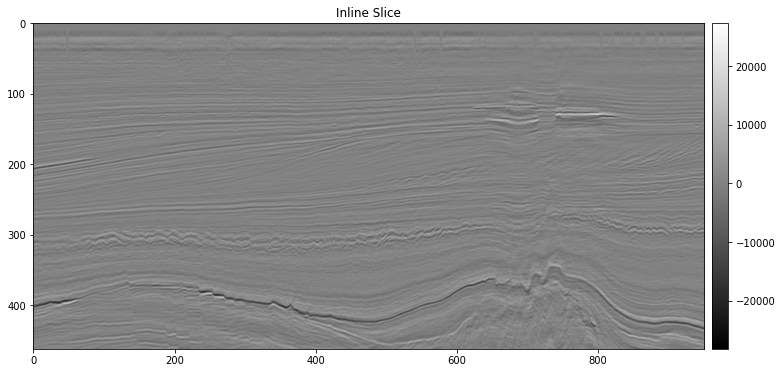

In [ ]:
def plot_slice(slice, title=None, cmap='gray', img_scale=0.015, interpolation='bicubic', is_discrete=False):
    img_h = int(slice.shape[0] * img_scale)
    img_w = int(slice.shape[1] * img_scale)    

    plt.figure(figsize=(img_w, img_h))
    if title: plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)
    
    if is_discrete:
        cmap = plt.get_cmap(cmap, np.max(slice)-np.min(slice)+1)
        im = ax.imshow(slice, cmap=cmap, interpolation=None, vmin = np.min(slice)-.5, vmax = np.max(slice)+.5)
        plt.colorbar(im, cax=cax, ticks=np.arange(np.min(slice),np.max(slice)+1))
    else:        
        im = ax.imshow(slice, cmap=cmap, interpolation=interpolation)
        plt.colorbar(im, cax=cax);
        
inline_index = 50
plot_slice(np.swapaxes(cube[inline_index,:,:], 0, 1), title='Inline Slice')

###**Attribute Computation**

To compute seismic attributes we will use [d2geo](https://github.com/jcfaracco/d2geo). This library has Python implementations in CPU and (few) GPU for the most common attributes used for processing and interpretation.

We are using a branch of the original repo with adjustments to run the latest Dask versions. To clone it:


In [ ]:
!git clone https://github.com/jcfaracco/d2geo.git -b new

Cloning into 'd2geo'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 192 (delta 81), reused 70 (delta 31), pack-reused 52
Receiving objects: 100% (192/192), 70.78 KiB | 14.16 MiB/s, done.
Resolving deltas: 100% (107/107), done.


For convenience, we will create a function to perform all necessary attribute calculations.

In [ ]:
def run_attributes(input_cube, attributes: List[Tuple[str, Callable, Dict[str, str]]]):
    datas = [attr_func(input_cube, **attr_kwargs).flatten() for _, attr_func, attr_kwargs in attributes]            
    datas = da.stack(datas, axis=1)
    return ddf.from_dask_array(datas, columns=[attr_name for attr_name, _, _ in attributes])

The attributes will be computed and stored in a Dask dataframe, which is a large parallel dataframe composed of many smaller Pandas DataFrames.

Notice that most d2geo attributes perform computations on CPU. Total time to process may vary depending upon your environment. This current attribute we are calculating was already ported to GPU.

In [ ]:
sys.path.append('./d2geo/attributes')

from d2geo.attributes.LBP import LBPAttributes

lbp_att = LBPAttributes()

# List of tuples with attribute name, the function 
# to run (with cube as input) and additional kwargs dict.
funcs = [
    ('LBP 3D Diagonal', lbp_att.local_binary_pattern_diag_3d, {}),
]

start = time.time()
dataframe = run_attributes(cube, funcs).compute()
end = time.time()

print("Time spent to calculate attributes:", end - start)

Time spent to calculate attributes: 10.236393690109253


###**Visualizing Attributes**

The dataframe representation considers rows being examples and columns attributes (features). It is necessary to re-order the output attribute dataframe to visualize the attributes as 2D sections.


In [ ]:
# Auxiliary function to correct indexing a given inline.
def slice_data(df, cube_shape, inline_index):
    slice_idx = (inline_index * cube_shape[1] * cube_shape[2],
                (inline_index + 1) * cube_shape[1] * cube_shape[2])

    slice_array = df[slice_idx[0] : slice_idx[1]]
    slice_array = slice_array.reshape(cube_shape[1], cube_shape[2])

    return slice_array.T

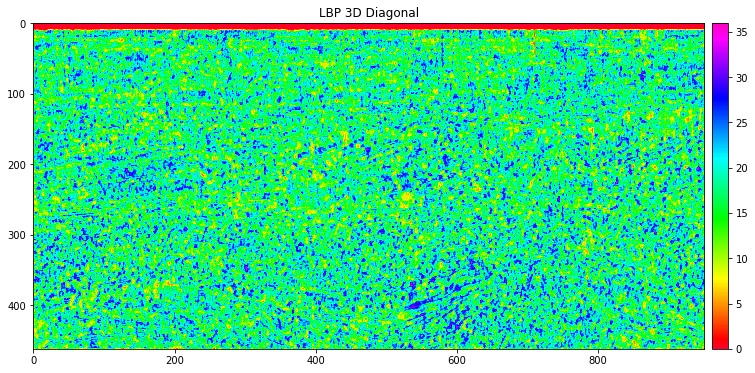

In [ ]:
# Attributes plotting according original list

att_list = [x[0] for x in funcs]
for att in att_list:
    s_data = slice_data(dataframe[att].values, cube.shape, inline_index)
    plot_slice(s_data, title=att, cmap='gist_rainbow')

###**Import Stratigraphic Library**

To analyze stratigraphic units, we are importing the original libraries from the original author. The module can be founded [here](https://github.com/ajbugge/StratigraphicUnits/blob/master/StratUnits_functions.py).

In [ ]:
import scipy.io
import numpy as np
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
import hdbscan
from sklearn import preprocessing


def trimSeismicAmplitudes(seismicCube, percentile):
    temp=seismicCube.copy()
    temp=temp.flatten()
    temp[temp<0]=0
    temp[temp != 0]
    pos_cutoff = np.percentile(temp, percentile) # return percentile
    temp=seismicCube.copy()
    temp=temp*-1
    temp=temp.flatten()
    temp[temp<0]=0
    temp[temp != 0]
    neg_cutoff = np.percentile(temp, percentile) # return percentile
    print ('new min and max are:', neg_cutoff, pos_cutoff)
    seismicCube[seismicCube>pos_cutoff]=pos_cutoff
    seismicCube[seismicCube<-neg_cutoff]=-neg_cutoff
    return seismicCube


#window_size=[50, 50, 50]
#step=10
import time
def generateFeaturevectors (seismicCube, textureCube, window_size, step):
    
    start = time.time()
    
    datashape=textureCube.shape
    edge_r=np.int(window_size[0]/2- step/2)
    edge_c=np.int(window_size[1]/2- step/2)
    edge_d=np.int(window_size[2]/2- step/2)
    minseis=np.min(seismicCube)
    maxseis=np.max(seismicCube)
    P=37
    
    layercake = np.zeros(seismicCube.shape)
    size_x = seismicCube.shape[0]
    for x in range (0, size_x):
        layercake[x, :, :]=x 
    
    feature_vectors=[]
    for r in range(0,datashape[0] - window_size[0], step):
        for c in range(0,datashape[1] - window_size[1], step):
            for d in range(0,datashape[2] - window_size[2], step):
                histograms=[]

                window = seismicCube[r:r+window_size[0],c:c+window_size[1], d:d+window_size[2]]        
                hist, _ = np.histogram(window, bins=P, range=(minseis, maxseis))
                histograms.append(hist)

                window = textureCube[r:r+window_size[0],c:c+window_size[1], d:d+window_size[2]]        
                hist, _ = np.histogram(window, bins=P, range=(0, 36))
                histograms.append(hist)

                feature_vector=np.concatenate(histograms)
                layercakewindow = layercake[r:r+window_size[0],c:c+window_size[1], d:d+window_size[2]]
                depth=np.int(np.mean(layercakewindow))
                feature_vector_depthconstrained=feature_vector+depth
                feature_vector_depthconstrained=feature_vector_depthconstrained.astype(np.float)
                feature_vectors.append(feature_vector_depthconstrained)

    #print(feature_vectors)
                
    feature_vectors = preprocessing.scale(feature_vectors)
    
    
    stop = time.time()
    t=(stop-start)/60
    print('generate feature vectors - time in minutes: ', t)
    
    return feature_vectors


# min_cluster_size=10000
# datashape=seismicCube.shape
def IdentifyStratUnits(feature_vectors, min_cluster_size, datashape, window_size, step):
    start = time.time()
    iteration=1
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size, min_samples=1, prediction_data=True)
    cluster_labels = clusterer.fit_predict(feature_vectors)
    
    #clusterer.condensed_tree_.plot()
    #plt.show()
    
    A=cluster_labels.copy()
    edge_r=np.int(window_size[0]/2- step/2)
    edge_c=np.int(window_size[1]/2- step/2)
    edge_d=np.int(window_size[2]/2- step/2)
    A=cluster_labels.copy()
    segmented=np.zeros(datashape, dtype=np.uint64)
    num=0
    print('iteration', iteration)
    for r in range(0,datashape[0] - window_size[0], step):
        for c in range(0,datashape[1] - window_size[1], step):
            for d in range(0,datashape[2] - window_size[2], step):
                segmented[r+edge_r:r+step+edge_r,c+edge_c:c+step+edge_c, d+edge_d:d+step+edge_d]=A[num]+1
                num=num+1
                
    unique_labels=A+1
    
    stop = time.time()
    t=(stop-start)/60
    print('identify units - time in minutes: ', t)
    return segmented, unique_labels


def FindNewUnits (firstIteration, splitlabel, seismicCube, textureCube, window_size, step, min_cluster_size):
    start = time.time()
    datashape=firstIteration.shape
    edge_r=np.int(window_size[0]/2- step/2)
    edge_c=np.int(window_size[1]/2- step/2)
    edge_d=np.int(window_size[2]/2- step/2)
    minseis=np.min(seismicCube)
    maxseis=np.max(seismicCube)
    minseis=np.min(seismicCube)
    maxseis=np.max(seismicCube)
    layercake = np.zeros(seismicCube.shape)
    size_x = seismicCube.shape[0]
    for x in range (0, size_x):
        layercake[x, :, :]=x 
    feature_vectors=[]
    for r in range(0,datashape[0] - window_size[0], step):
        for c in range(0,datashape[1] - window_size[1], step):
            for d in range(0,datashape[2] - window_size[2], step):
                #check if already classified    
                window = firstIteration[r+edge_r:r+step+edge_r,c+edge_c:c+step+edge_c, d+edge_d:d+step+edge_d]
                if window[0, 0, 0] == splitlabel:
                    histograms=[]

                    window = seismicCube[r:r+window_size[0],c:c+window_size[1], d:d+window_size[2]]        
                    hist, _ = np.histogram(window, bins=37, range=(minseis, maxseis))
                    histograms.append(hist)

                    window = textureCube[r:r+window_size[0],c:c+window_size[1], d:d+window_size[2]]        
                    hist, _ = np.histogram(window, bins=37, range=(0, 36))
                    histograms.append(hist)

                    feature_vector=np.concatenate(histograms)
                    layercakewindow = layercake[r:r+window_size[0],c:c+window_size[1], d:d+window_size[2]]
                    depth=np.int(np.mean(layercakewindow))
                    feature_vector_depthconstrained=feature_vector+depth
                    feature_vector_depthconstrained=feature_vector_depthconstrained.astype(np.float)
                    feature_vectors.append(feature_vector_depthconstrained)
    new_units=np.zeros(datashape, dtype=np.uint64)
    print(len(feature_vectors))
    
    if len(feature_vectors) > 0:
        feature_vectors = preprocessing.scale(feature_vectors)
        clusterer = hdbscan.HDBSCAN(min_cluster_size, min_samples=1, allow_single_cluster=False)
        cluster_labels = clusterer.fit_predict(feature_vectors)
        
        #clusterer.condensed_tree_.plot()
        #plt.show()
        
        A=cluster_labels.copy()
        num=0
        for r in range(0,datashape[0] - window_size[0], step):
            for c in range(0,datashape[1] - window_size[1], step):
                for d in range(0,datashape[2] - window_size[2], step):
                    window = firstIteration[r+edge_r:r+step+edge_r,c+edge_c:c+step+edge_c, d+edge_d:d+step+edge_d]
                    if window[0, 0, 0] == splitlabel:
                        new_units[r+edge_r:r+step+edge_r,c+edge_c:c+step+edge_c, d+edge_d:d+step+edge_d]=A[num]+1
                        num=num+1
                        
    stop = time.time()
    t=(stop-start)/60
    print('new iteration - time in minutes: ', t)
    return new_units


def iteratively_identify_stratUnits(seismicCube, textureCube, window_size, step, min_cluster_fraction):
    print('generate feature vectors....')
    feature_vectors=generateFeaturevectors(seismicCube, textureCube, window_size, step)
    min_cluster_size=np.int(len(feature_vectors)/min_cluster_fraction)
    print('minimum cluster size is..', min_cluster_size)
    
    iterations=[]

    #min_cluster_size=np.int(len(feature_vectors)/25)
    print('feature vectors', len(feature_vectors))
    print('min_cluster_size', min_cluster_size)


    datashape=seismicCube.shape
    print('HDBSCAN.......')
    segmented, unique_labels = IdentifyStratUnits(feature_vectors, min_cluster_size, datashape, window_size, step)
    iterations.append(segmented)
    
    print('first iteration....')
    plt.imshow(segmented[50,:,:], aspect='auto')
    plt.colorbar()
    plt.show()

    for i in np.unique(unique_labels):
        x = np.count_nonzero(unique_labels == i)
        percent=x/len(unique_labels)
        if percent > 0.80:
            print('Second iteration. split label:', i)
            splitlabel=i

            segmented2=FindNewUnits(segmented, splitlabel, seismicCube, textureCube, window_size, step, min_cluster_size)
            plt.imshow(segmented2[50,:,:], aspect='auto')
            plt.colorbar()
            plt.show()

            segmented1=segmented.copy()
            segmented1[segmented1==i]=0
            start=np.max(segmented2)
            for j in range (1, np.int(np.max(segmented1))+1):
                segmented1[segmented1==j]=start+j
                
            segmented=segmented1+segmented2
            iterations.append(segmented)
            #plt.imshow(segmented[:,50,:], aspect='auto')
            #plt.colorbar()
            #plt.show()

    if segmented.any():
        splitlabel=0
        new_units=FindNewUnits(segmented, splitlabel, seismicCube, textureCube, window_size, step, min_cluster_size)
        start=np.max(segmented)
        for i in range (1, np.int(np.max(new_units))+1):
            new_units[new_units==i]=start+i
        final=new_units+segmented
        print('Final iteration')
        plt.imshow(final[50,:,:], aspect='auto')
        plt.colorbar()
        plt.show()
        iterations.append(final)
        print(len(iterations), 'cubes are returned')
    return iterations

###**Convert Raw Data**

The next stage converts the raw data into proper x,y,z orientation. To indentify the stratigraphic units properly, the cube should be defined in the proper orientation. 

The cube imported by **segyio** is rotated 90 degrees from axle Z. It is possible to confirm by seeing the usage of swapaxes in many plot calls.

In [ ]:
# Convert the original cube in the proper visualization
# format with swapaxes() function.

# You can use the full depth with cube.shape[0]
# but due to memory limits, we will use 100 slices.
inlines = 100
att_lbp = 'LBP 3D Diagonal'

new_swap_cube = list()
texture_swap_descriptor = list()
for i in range(0, inlines):
    new_swap_cube.append(np.swapaxes(cube[i,:,:], 0, 1))
    texture_swap_descriptor.append(slice_data(dataframe[att_lbp].values,
                                   cube.shape, i))

new_swap_cube = np.array(new_swap_cube)
texture_swap_descriptor = np.array(texture_swap_descriptor)

###**Stratigraphic Analysis**

The final stage is the seismic stratigraphic analisys using HDBSCAN according the original library defined by the author.

generate feature vectors....
generate feature vectors - time in minutes:  1.2598078767458598
minimum cluster size is.. 764
feature vectors 19110
min_cluster_size 764
HDBSCAN.......
iteration 1
identify units - time in minutes:  0.3286377668380737
first iteration....


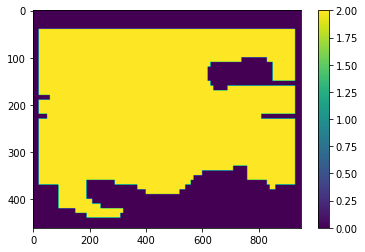

4856
new iteration - time in minutes:  0.32905255953470863
Final iteration


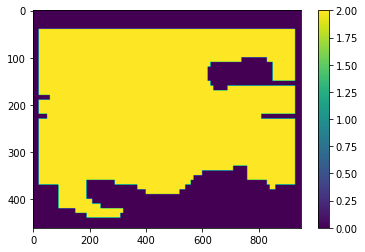

2 cubes are returned
 time in minutes:  1.9296044071515401


In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import hdbscan
from sklearn import preprocessing

start = time.time()

step = 10
window_size = [50, 50, 50]
min_cluster_fraction = 25

units = iteratively_identify_stratUnits(new_swap_cube, texture_swap_descriptor, window_size, step, min_cluster_fraction)

stop = time.time()
t=(stop-start)/60
print(' time in minutes: ', t)